In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from sklearn import preprocessing

In [2]:
# Import csv with crime and income data
crime_income_df = pd.read_csv('income_crime.csv')
crime_income_df.head()

,Unnamed: 0,city,state,20th,40th,Median,60th,80th,95th,murders,...,burglaries,burglariesper100k,thefts,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,crime index,income inequality
0,0,Alabaster,Alabama,33578,61734,73325,85277,122176,177359,0.0,...,44.0,132.3,462.0,1389.3,21.0,63.2,NaN,NaN,115.9,143781
1,1,Albertville,Alabama,17270,27280,32042,43119,73798,128375,0.0,...,145.0,671.7,413.0,1913.1,90.0,416.9,NaN,NaN,200.0,111105
2,2,Anniston,Alabama,12553,22337,30539,39541,65472,143838,14.0,...,542.0,2468.7,700.0,3188.3,110.0,501.0,NaN,NaN,1302.8,131285
3,3,Athens,Alabama,16777,33804,45920,57566,104817,199193,1.0,...,86.0,330.7,597.0,2295.8,12.0,46.1,NaN,NaN,140.2,182416
4,4,Auburn,Alabama,10718,26433,38912,53137,106853,198103,4.0,...,156.0,240.6,1454.0,2242.8,101.0,155.8,NaN,NaN,217.4,187385


In [3]:
# Drop the Unnamed column which is the same as the index values
crime_income_df = crime_income_df.drop(['Unnamed: 0'], axis = 1)

Now let's add in the quintile ratios. This index of inequality will be the 80th percentile's value divided by the 20th percentile's value. This is known as the Quintile Share, and the EU uses this to monitor income distribution in countries.(According to source). 

In [4]:
# Zipping the quintiles together so they're easy to digest in a function. 
quintile_values = list(zip(list(crime_income_df['20th']),list(crime_income_df['80th'])))
# iterate through the tuples, creating the quintile share. Then, appending that to a list,
# which will become our quintile ratio column.
quintile_share = []
for i in range(len(quintile_values)):
    val = quintile_values[i][1] / quintile_values[i][0]
    quintile_share.append(val)
crime_income_df["quintile share"] = pd.Series(quintile_share)

crime_income_df.head()

,city,state,20th,40th,Median,60th,80th,95th,murders,murdersper100k,...,burglariesper100k,thefts,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,crime index,income inequality,quintile share
0,Alabaster,Alabama,33578,61734,73325,85277,122176,177359,0.0,0.0,...,132.3,462.0,1389.3,21.0,63.2,NaN,NaN,115.9,143781,3.638573
1,Albertville,Alabama,17270,27280,32042,43119,73798,128375,0.0,0.0,...,671.7,413.0,1913.1,90.0,416.9,NaN,NaN,200.0,111105,4.273191
2,Anniston,Alabama,12553,22337,30539,39541,65472,143838,14.0,63.8,...,2468.7,700.0,3188.3,110.0,501.0,NaN,NaN,1302.8,131285,5.215646
3,Athens,Alabama,16777,33804,45920,57566,104817,199193,1.0,3.8,...,330.7,597.0,2295.8,12.0,46.1,NaN,NaN,140.2,182416,6.247660
4,Auburn,Alabama,10718,26433,38912,53137,106853,198103,4.0,6.2,...,240.6,1454.0,2242.8,101.0,155.8,NaN,NaN,217.4,187385,9.969491


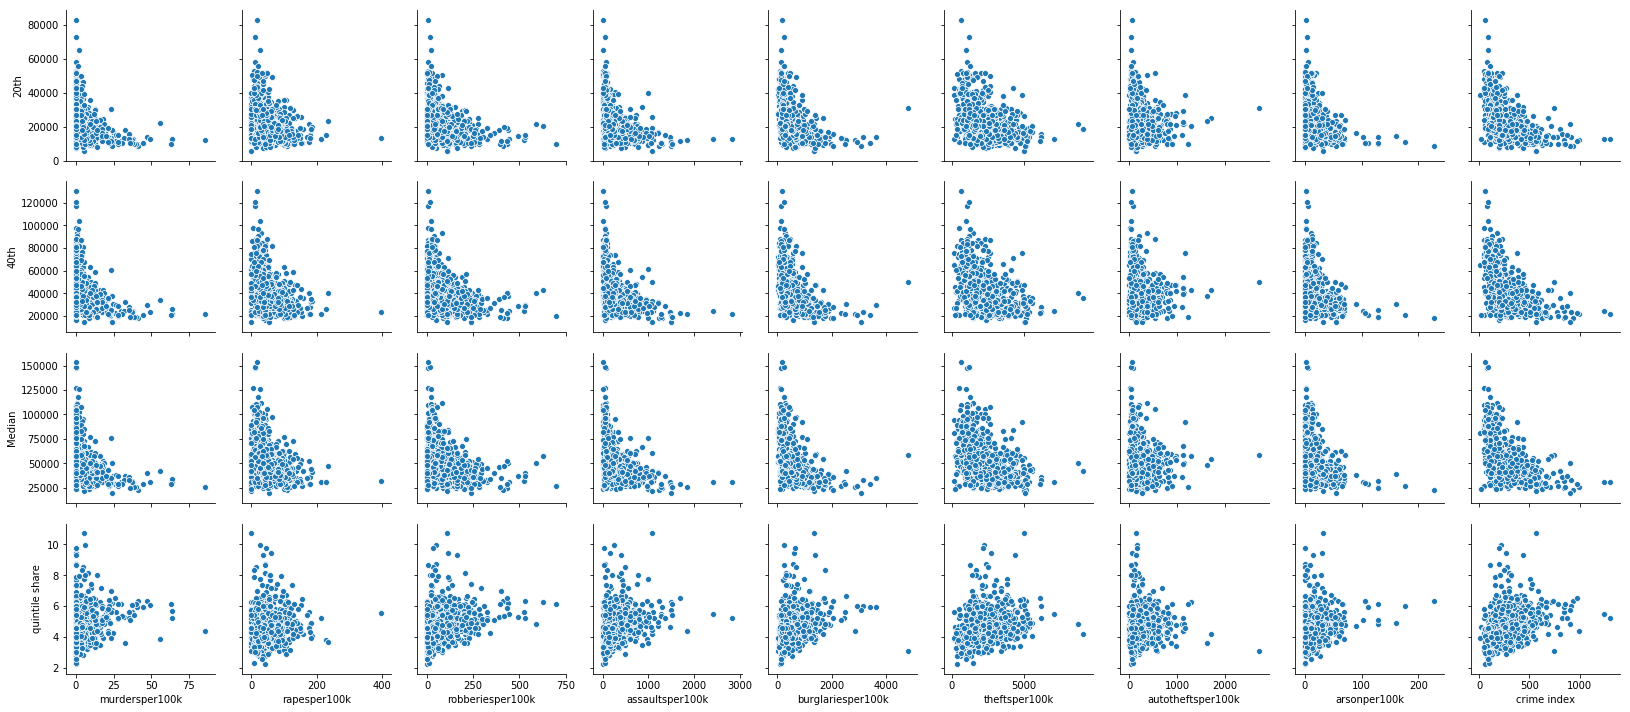

In [5]:
# Create a pair plot with income columns and crime per 100,000 based on population
sns.pairplot(crime_income_df, y_vars = ['20th', '40th', 'Median', 'quintile share'],
             x_vars = ['murdersper100k', 'rapesper100k', 'robberiesper100k', 'assaultsper100k', 'burglariesper100k', 'theftsper100k', 'autotheftsper100k', 'arsonper100k', 'crime index'])

Visually speaking, it seems very clear that poverty connects with crime. Places with wealthier 20th percentiles have low crime, and places with poorer 20th percentiles have more crime. The same is true of the median and 40th percentiles. The relationship with the Quintile Share seems a little more complicated.Recall that a higher quintile share indicates a higher level of inequality. There seems to be a soft trend where the quintile share does relate to level of crime, but it is by no means a firm one.

In [6]:
# Get general statistics for income and crime data
(crime_income_df.describe()).round()

,20th,40th,Median,60th,80th,95th,murders,murdersper100k,rapes,rapesper100k,...,burglariesper100k,thefts,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,crime index,income inequality,quintile share
count,924.0,924.0,924.0,924.0,924.0,924.0,924.0,924.0,912.0,912.0,...,920.0,922.0,922.0,923.0,923.0,866.0,866.0,924.0,924.0,924.0
mean,22906.0,41615.0,52190.0,64373.0,99164.0,166271.0,6.0,5.0,42.0,50.0,...,553.0,1772.0,2257.0,275.0,232.0,15.0,15.0,274.0,143365.0,5.0
std,9625.0,15647.0,18687.0,21774.0,30441.0,40941.0,29.0,8.0,118.0,37.0,...,464.0,4456.0,1154.0,915.0,221.0,54.0,20.0,165.0,34556.0,1.0
min,5800.0,14972.0,19810.0,24911.0,44900.0,87338.0,0.0,0.0,0.0,0.0,...,30.0,7.0,140.0,0.0,0.0,0.0,0.0,12.0,68478.0,2.0
25%,16321.0,31220.0,39952.0,50241.0,79207.0,135346.0,0.0,0.0,5.0,23.0,...,250.0,322.0,1412.0,18.0,93.0,1.0,3.0,155.0,117151.0,4.0
50%,20567.0,37912.0,48156.0,59792.0,92406.0,157230.0,1.0,2.0,13.0,42.0,...,423.0,698.0,2083.0,51.0,168.0,3.0,10.0,236.0,136314.0,4.0
75%,27436.0,48671.0,60354.0,73607.0,110632.0,189094.0,3.0,7.0,35.0,68.0,...,703.0,1621.0,2938.0,166.0,294.0,10.0,20.0,352.0,163504.0,5.0
max,82565.0,130119.0,153253.0,180125.0,250001.0,250001.0,653.0,86.0,1762.0,396.0,...,4809.0,67828.0,9071.0,11596.0,2702.0,869.0,228.0,1303.0,233753.0,11.0


/Users/elise/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


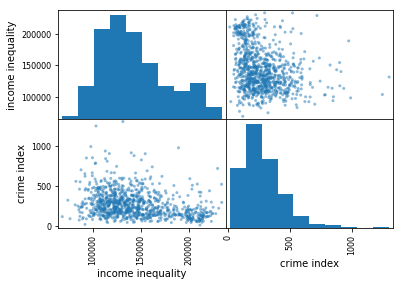

In [7]:
pd.scatter_matrix(crime_income_df[['income inequality','crime index']])

f1 = plt.gcf()

In [8]:
df_crimeper100 = crime_income_df[['quintile share', 'murdersper100k', 'rapesper100k', 'robberiesper100k', 'assaultsper100k',
                            'burglariesper100k', 'theftsper100k', 'autotheftsper100k', 'arsonper100k', 'crime index']]
df_crimeper100.head()

,quintile share,murdersper100k,rapesper100k,robberiesper100k,assaultsper100k,burglariesper100k,theftsper100k,autotheftsper100k,arsonper100k,crime index
0,3.638573,0.0,0.0,15.0,207.5,132.3,1389.3,63.2,NaN,115.9
1,4.273191,0.0,32.4,32.4,37.1,671.7,1913.1,416.9,NaN,200.0
2,5.215646,63.8,214.1,323.4,2833.1,2468.7,3188.3,501.0,NaN,1302.8
3,6.247660,3.8,0.0,46.1,0.0,330.7,2295.8,46.1,NaN,140.2
4,9.969491,6.2,26.2,46.3,256.1,240.6,2242.8,155.8,NaN,217.4


In [9]:
corrs_crimeper100 = df_crimeper100.corr()
corrs_crimeper100

,quintile share,murdersper100k,rapesper100k,robberiesper100k,assaultsper100k,burglariesper100k,theftsper100k,autotheftsper100k,arsonper100k,crime index
quintile share,1.000000,0.263979,0.135648,0.341071,0.298336,0.315672,0.288744,0.073394,0.208815,0.359841
murdersper100k,0.263979,1.000000,0.170459,0.606552,0.571986,0.505855,0.315939,0.310346,0.386974,0.650385
rapesper100k,0.135648,0.170459,1.000000,0.269519,0.378451,0.278477,0.278684,0.264664,0.264512,0.531987
robberiesper100k,0.341071,0.606552,0.269519,1.000000,0.573215,0.518289,0.460329,0.564758,0.377354,0.762285
assaultsper100k,0.298336,0.571986,0.378451,0.573215,1.000000,0.544664,0.438096,0.334505,0.342515,0.830321
burglariesper100k,0.315672,0.505855,0.278477,0.518289,0.544664,1.000000,0.563583,0.464945,0.397116,0.776285
theftsper100k,0.288744,0.315939,0.278684,0.460329,0.438096,0.563583,1.000000,0.456257,0.288854,0.746923
autotheftsper100k,0.073394,0.310346,0.264664,0.564758,0.334505,0.464945,0.456257,1.000000,0.296172,0.612149
arsonper100k,0.208815,0.386974,0.264512,0.377354,0.342515,0.397116,0.288854,0.296172,1.000000,0.464297
crime index,0.359841,0.650385,0.531987,0.762285,0.830321,0.776285,0.746923,0.612149,0.464297,1.000000


    There seems to be a fairly solid correlation here; 0.35 is certainly less correlated than some of the other values we're seeing, but it makes sense that individual types of crime per 100k would be very strongly related with the crime index, since they more or less determine it.   
    We will now check crime index against different percentiles (specifically 20th, Median, and 95th) of income instead of against the quintile share. This will give us an idea how poverty in and of itself contributes to the problem.

In [10]:
df_20thper100 = crime_income_df[['20th', 'murdersper100k', 'rapesper100k', 'robberiesper100k', 'assaultsper100k',
                            'burglariesper100k', 'theftsper100k', 'autotheftsper100k', 'arsonper100k', 'crime index']]
corrs_20thper100 = df_20thper100.corr()
corrs_20thper100

,20th,murdersper100k,rapesper100k,robberiesper100k,assaultsper100k,burglariesper100k,theftsper100k,autotheftsper100k,arsonper100k,crime index
20th,1.000000,-0.339197,-0.331618,-0.350650,-0.416062,-0.441973,-0.407847,-0.173704,-0.294415,-0.514839
murdersper100k,-0.339197,1.000000,0.170459,0.606552,0.571986,0.505855,0.315939,0.310346,0.386974,0.650385
rapesper100k,-0.331618,0.170459,1.000000,0.269519,0.378451,0.278477,0.278684,0.264664,0.264512,0.531987
robberiesper100k,-0.350650,0.606552,0.269519,1.000000,0.573215,0.518289,0.460329,0.564758,0.377354,0.762285
assaultsper100k,-0.416062,0.571986,0.378451,0.573215,1.000000,0.544664,0.438096,0.334505,0.342515,0.830321
burglariesper100k,-0.441973,0.505855,0.278477,0.518289,0.544664,1.000000,0.563583,0.464945,0.397116,0.776285
theftsper100k,-0.407847,0.315939,0.278684,0.460329,0.438096,0.563583,1.000000,0.456257,0.288854,0.746923
autotheftsper100k,-0.173704,0.310346,0.264664,0.564758,0.334505,0.464945,0.456257,1.000000,0.296172,0.612149
arsonper100k,-0.294415,0.386974,0.264512,0.377354,0.342515,0.397116,0.288854,0.296172,1.000000,0.464297
crime index,-0.514839,0.650385,0.531987,0.762285,0.830321,0.776285,0.746923,0.612149,0.464297,1.000000


The negative correlation between the 20th percentile of income against crimes per 100k is a lot stronger than simply against counts of crime. Aside from autothefts at correlation -0.173704, all the other crimes have a correlation between -0.45 and -0.29 with income's 20th percentile.

In [11]:
df_Medper100 = crime_income_df[['Median', 'murdersper100k', 'rapesper100k', 'robberiesper100k', 'assaultsper100k',
                            'burglariesper100k', 'theftsper100k', 'autotheftsper100k', 'arsonper100k', 'crime index']]
corrs_Medper100 = df_Medper100.corr()
corrs_Medper100

,Median,murdersper100k,rapesper100k,robberiesper100k,assaultsper100k,burglariesper100k,theftsper100k,autotheftsper100k,arsonper100k,crime index
Median,1.000000,-0.336887,-0.342925,-0.316938,-0.412161,-0.452121,-0.408438,-0.177613,-0.286220,-0.512659
murdersper100k,-0.336887,1.000000,0.170459,0.606552,0.571986,0.505855,0.315939,0.310346,0.386974,0.650385
rapesper100k,-0.342925,0.170459,1.000000,0.269519,0.378451,0.278477,0.278684,0.264664,0.264512,0.531987
robberiesper100k,-0.316938,0.606552,0.269519,1.000000,0.573215,0.518289,0.460329,0.564758,0.377354,0.762285
assaultsper100k,-0.412161,0.571986,0.378451,0.573215,1.000000,0.544664,0.438096,0.334505,0.342515,0.830321
burglariesper100k,-0.452121,0.505855,0.278477,0.518289,0.544664,1.000000,0.563583,0.464945,0.397116,0.776285
theftsper100k,-0.408438,0.315939,0.278684,0.460329,0.438096,0.563583,1.000000,0.456257,0.288854,0.746923
autotheftsper100k,-0.177613,0.310346,0.264664,0.564758,0.334505,0.464945,0.456257,1.000000,0.296172,0.612149
arsonper100k,-0.286220,0.386974,0.264512,0.377354,0.342515,0.397116,0.288854,0.296172,1.000000,0.464297
crime index,-0.512659,0.650385,0.531987,0.762285,0.830321,0.776285,0.746923,0.612149,0.464297,1.000000


Once again, similar to what we saw for the 20th percentile, for the Median, there is a stronger negative correlation between income and crime per 100k than between income and just counts of crime. Against crime index, the negative correlation is -0.512659.

In [12]:
df_crimes95th = crime_income_df[['95th', 'murders', 'rapes', 'robberies', 'assaults', 'burglaries',
                            'thefts', 'autothefts', 'arson', 'crime index']]
corrs_crime95th = df_crimes95th.corr()
corrs_crime95th

,95th,murders,rapes,robberies,assaults,burglaries,thefts,autothefts,arson,crime index
95th,1.000000,0.043645,0.102029,0.091760,0.061087,0.081883,0.143141,0.119729,0.043988,-0.354678
murders,0.043645,1.000000,0.862368,0.936754,0.919617,0.833576,0.833418,0.841418,0.815199,0.283830
rapes,0.102029,0.862368,1.000000,0.889155,0.895275,0.929920,0.940481,0.916935,0.809375,0.297544
robberies,0.091760,0.936754,0.889155,1.000000,0.936240,0.882402,0.906019,0.886478,0.805558,0.249056
assaults,0.061087,0.919617,0.895275,0.936240,1.000000,0.922824,0.902541,0.905438,0.875458,0.332169
burglaries,0.081883,0.833576,0.929920,0.882402,0.922824,1.000000,0.950431,0.931868,0.866981,0.356247
thefts,0.143141,0.833418,0.940481,0.906019,0.902541,0.950431,1.000000,0.919373,0.789279,0.296065
autothefts,0.119729,0.841418,0.916935,0.886478,0.905438,0.931868,0.919373,1.000000,0.893262,0.305074
arson,0.043988,0.815199,0.809375,0.805558,0.875458,0.866981,0.789279,0.893262,1.000000,0.342006
crime index,-0.354678,0.283830,0.297544,0.249056,0.332169,0.356247,0.296065,0.305074,0.342006,1.000000


In [13]:
df_95thper100 = crime_income_df[['95th', 'murdersper100k', 'rapesper100k', 'robberiesper100k', 'assaultsper100k',
                            'burglariesper100k', 'theftsper100k', 'autotheftsper100k', 'arsonper100k', 'crime index']]
corrs_95thper100 = df_95thper100.corr()
corrs_95thper100

,95th,murdersper100k,rapesper100k,robberiesper100k,assaultsper100k,burglariesper100k,theftsper100k,autotheftsper100k,arsonper100k,crime index
95th,1.000000,-0.240329,-0.302745,-0.130805,-0.302601,-0.342421,-0.257003,-0.091805,-0.238494,-0.354678
murdersper100k,-0.240329,1.000000,0.170459,0.606552,0.571986,0.505855,0.315939,0.310346,0.386974,0.650385
rapesper100k,-0.302745,0.170459,1.000000,0.269519,0.378451,0.278477,0.278684,0.264664,0.264512,0.531987
robberiesper100k,-0.130805,0.606552,0.269519,1.000000,0.573215,0.518289,0.460329,0.564758,0.377354,0.762285
assaultsper100k,-0.302601,0.571986,0.378451,0.573215,1.000000,0.544664,0.438096,0.334505,0.342515,0.830321
burglariesper100k,-0.342421,0.505855,0.278477,0.518289,0.544664,1.000000,0.563583,0.464945,0.397116,0.776285
theftsper100k,-0.257003,0.315939,0.278684,0.460329,0.438096,0.563583,1.000000,0.456257,0.288854,0.746923
autotheftsper100k,-0.091805,0.310346,0.264664,0.564758,0.334505,0.464945,0.456257,1.000000,0.296172,0.612149
arsonper100k,-0.238494,0.386974,0.264512,0.377354,0.342515,0.397116,0.288854,0.296172,1.000000,0.464297
crime index,-0.354678,0.650385,0.531987,0.762285,0.830321,0.776285,0.746923,0.612149,0.464297,1.000000


We see something different at the 95th percentile of income. When checking against counts of crime, there seems to be a positive correlation, although low, with rapes (0.102029), thefts (0.143141), and autothefts (0.119729) at a stronger correlation with the 95th than other crimes are.

Correlation is negative once again though when we check income's 95th percentile against the crimes per 100k in the population. Against the crime index, we have a correlation of -0.354678.

In [14]:
# Create 'ineq_exists' column: '1' if exists, '0' if doesn't
# Income inequality defined as >= median of all income inequalities
income_ineq_median = crime_income_df["quintile share"].median()

ineq_exists = [0]*len(crime_income_df)
for i in range(0,len(crime_income_df)):
    if crime_income_df["quintile share"][i] >= income_ineq_median:
        ineq_exists[i] = 1
    else:
        ineq_exists[i] = 0
crime_income_df['inequality exists'] = ineq_exists  
crime_income_df

,city,state,20th,40th,Median,60th,80th,95th,murders,murdersper100k,...,thefts,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,crime index,income inequality,quintile share,inequality exists
0,Alabaster,Alabama,33578,61734,73325,85277,122176,177359,0.0,0.0,...,462.0,1389.3,21.0,63.2,NaN,NaN,115.9,143781,3.638573,0
1,Albertville,Alabama,17270,27280,32042,43119,73798,128375,0.0,0.0,...,413.0,1913.1,90.0,416.9,NaN,NaN,200.0,111105,4.273191,0
2,Anniston,Alabama,12553,22337,30539,39541,65472,143838,14.0,63.8,...,700.0,3188.3,110.0,501.0,NaN,NaN,1302.8,131285,5.215646,1
3,Athens,Alabama,16777,33804,45920,57566,104817,199193,1.0,3.8,...,597.0,2295.8,12.0,46.1,NaN,NaN,140.2,182416,6.247660,1
4,Auburn,Alabama,10718,26433,38912,53137,106853,198103,4.0,6.2,...,1454.0,2242.8,101.0,155.8,NaN,NaN,217.4,187385,9.969491,1
5,Bessemer,Alabama,12497,24200,30682,39724,68488,115894,10.0,37.9,...,1867.0,7082.7,219.0,830.8,NaN,NaN,1247.9,103397,5.480355,1
6,Birmingham,Alabama,12217,24676,32404,41532,68837,125611,79.0,37.2,...,8838.0,4163.2,1515.0,713.6,145.0,68.3,841.0,113394,5.634526,1
7,Cullman,Alabama,15091,33146,40129,49040,80061,131531,1.0,6.4,...,505.0,3234.5,39.0,249.8,NaN,NaN,251.8,116440,5.305215,1
8,Daphne,Alabama,24224,48136,61508,76649,118944,203269,0.0,0.0,...,464.0,1739.8,18.0,67.5,NaN,NaN,125.5,179045,4.910172,1
9,Decatur,Alabama,16869,32375,42602,54318,88674,154311,9.0,16.4,...,1680.0,3056.9,173.0,314.8,NaN,NaN,335.7,137442,5.256625,1


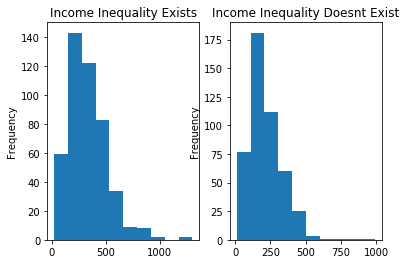

In [15]:
# Side-by-side histogram plots of crime index in areas with and without income inequality
fig, axes = plt.subplots(1, 2)

crime_income_df[crime_income_df["inequality exists"] == 1]["crime index"].plot.hist(ax = axes[0], title = 'Income Inequality Exists')
crime_income_df[crime_income_df["inequality exists"] == 0]["crime index"].plot.hist(ax = axes[1], title = 'Income Inequality Doesn''t Exist')


In [16]:
crime_ineq = crime_income_df[crime_income_df["inequality exists"] == 1]["crime index"].values
crime_no_ineq = crime_income_df[crime_income_df["inequality exists"] == 0]["crime index"].values

st_ineq, p_ineq = normaltest(crime_ineq)
st_no_ineq, p_no_ineq = normaltest(crime_no_ineq)

is_n_ineq = bool(p_ineq > 0.01)
if is_n_ineq == True:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
is_n_no_ineq = bool(p_no_ineq > 0.01)
if is_n_no_ineq == True:
    print('The distribution of crime index for income inequality not existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality not existing is not approximately normal.')


The distribution of crime index for income inequality existing is not approximately normal.
The distribution of crime index for income inequality not existing is not approximately normal.


Our data isn't normal, so it's not possible to run certain kinds of tests on it. Let's try to normalize our data really quick. We are using the normalize funtion from sklearn, and we are also doing a cuberoot transformation.

In [17]:
print(len(crime_ineq))

crime_ineq = pd.Series(crime_ineq)

crime_no_ineq = pd.Series(crime_no_ineq)





crime_ineq =    pd.DataFrame(preprocessing.normalize([crime_ineq],norm='max'))
crime_ineq = crime_ineq.transpose()
crime_ineq = pd.DataFrame(np.cbrt(crime_ineq))



crime_no_ineq = pd.DataFrame(preprocessing.normalize([crime_no_ineq],norm='max'))
crime_no_ineq = crime_no_ineq.transpose()
crime_no_ineq = pd.DataFrame(np.cbrt(crime_no_ineq))



print(len(crime_ineq))

462
462


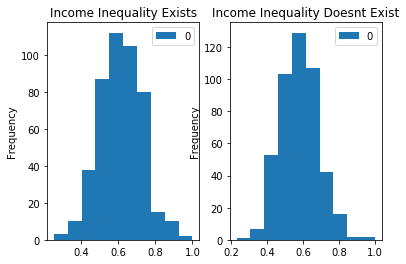

In [18]:
fig, axes = plt.subplots(1, 2)

crime_ineq.plot.hist(ax = axes[0], title = 'Income Inequality Exists')
crime_no_ineq.plot.hist(ax = axes[1], title = 'Income Inequality Doesn''t Exist')


Ok let's see if we got it to be normal

In [19]:
st_ineq, p_ineq = normaltest(crime_ineq)
st_no_ineq, p_no_ineq = normaltest(crime_no_ineq)

is_n_ineq = bool(p_ineq > 0.01)
if is_n_ineq == True:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
is_n_no_ineq = bool(p_no_ineq > 0.01)
if is_n_no_ineq == True:
    print('The distribution of crime index for income inequality not existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality not existing is not approximately normal.')
    
print(p_ineq,p_no_ineq)

The distribution of crime index for income inequality existing is approximately normal.
The distribution of crime index for income inequality not existing is approximately normal.
[0.5475311] [0.03667113]


Success! Now that we have approximately normal distributions, we can do some more testing.

In [20]:
t_val, p_val = ttest_ind(crime_ineq, crime_no_ineq)

if p_val < 0.01:
    print('There is a significant difference.')
else:
    print('There is NOT a significant difference.')


There is a significant difference.


After performing a 2-sample t-test, we can conclude that there is indeed a significant difference in crime index between areas where income inequality exists and areas where income inequality doesn't exist.



But maybe this effect is due to a confound, namely poverty in and of itself...

In [21]:
# Create 'poverty_exists' column: '1' if exists, '0' if doesn't
# poverty defined as 20th percentile income < mean of all 20th percentile incomes
mean20th = crime_income_df["20th"].mean()

pov_exists = [0]*len(crime_income_df)
for i in range(0,len(crime_income_df)):
    if crime_income_df["20th"][i] < mean20th:
        pov_exists[i] = 0
    else:
        pov_exists[i] = 1
crime_income_df['poverty exists'] = pov_exists  
crime_income_df.head()

,city,state,20th,40th,Median,60th,80th,95th,murders,murdersper100k,...,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,crime index,income inequality,quintile share,inequality exists,poverty exists
0,Alabaster,Alabama,33578,61734,73325,85277,122176,177359,0.0,0.0,...,1389.3,21.0,63.2,NaN,NaN,115.9,143781,3.638573,0,1
1,Albertville,Alabama,17270,27280,32042,43119,73798,128375,0.0,0.0,...,1913.1,90.0,416.9,NaN,NaN,200.0,111105,4.273191,0,0
2,Anniston,Alabama,12553,22337,30539,39541,65472,143838,14.0,63.8,...,3188.3,110.0,501.0,NaN,NaN,1302.8,131285,5.215646,1,0
3,Athens,Alabama,16777,33804,45920,57566,104817,199193,1.0,3.8,...,2295.8,12.0,46.1,NaN,NaN,140.2,182416,6.247660,1,0
4,Auburn,Alabama,10718,26433,38912,53137,106853,198103,4.0,6.2,...,2242.8,101.0,155.8,NaN,NaN,217.4,187385,9.969491,1,0


In [22]:
print(len(crime_income_df[crime_income_df['poverty exists'] == 0]))
print(len(crime_income_df[crime_income_df['poverty exists'] == 1]))

561
363


As we can see, based on our defintion of poverty, 561 counties do not experience poverty while 363 counties do.

Using `value_counts` from pandas, extract the number of 'poverty exists' and 'poverty doesn't exist', separately for 'income inequality exists' and 'income inequality doesn't exist'. 

To do so:

- select from `crime_income_df` income inequality, 0 and 1 separately, extract the poverty exists column, and use the `value_counts` method.
- Save the counts for each 'poverty does/doesn't exist' for 'income inequality exists' to a variable called `pov_ineq`
- Save the counts for each 'poverty does/doesn't exist' for 'income inequality doesn't exist' to a variable called `pov_no_ineq`


In [23]:
pov_ineq = crime_income_df[crime_income_df['inequality exists'] == 1]['poverty exists'].value_counts()
pov_no_ineq = crime_income_df[crime_income_df['inequality exists'] == 0]['poverty exists'].value_counts()

In [24]:
print(pov_ineq)
print(pov_no_ineq)

0    409
1     53
Name: poverty exists, dtype: int64
1    310
0    152
Name: poverty exists, dtype: int64


What we saw from above is that of all the areas WITH income inequality, 409 counties do not experience poverty while 53 do. Meanwhile in all the areas WITHOUT income inequality, 310 counties DO experience poverty while 152 do not. 

Let's find the ratio of poverty existing, the proportion of counties with poverty, in 'income inequality exists' and 'income inequality doesn't exist'. This will be value between 0.0 and 1.0, calculated as #(pov == 1) / (#(pov == 0) + #(pov == 1) - done separately for income inequality existing and not existing.

We will use the `pov_ineq` and `pov_no_ineq` variables to calculate these.

Save the ratio of poverty existing in 'inequality exists' to a variable `r_ineq`.

Save the ratio of poverty existing in 'inequality doesn't exist' to a variable `r_no_ineq`.

Note: keep these numbers as ratios (they should be decimal numbers, less than 1).


In [25]:
r_ineq = pov_ineq[1]/(pov_ineq[0] + pov_ineq[1])
r_no_ineq = pov_no_ineq[1]/(pov_no_ineq[0] + pov_no_ineq[1])

In [26]:
print(r_ineq)
print(r_no_ineq)

0.11471861471861472
0.670995670995671


The ratio of poverty existing in the two categories appear very different, but we will use a chi-squared test to see whether the difference in poverty-ratio between 'income inequality does/doesn't exist' is significantly different.

In [27]:
chisq, p_val_chi = stats.chisquare(np.array([pov_ineq.values, pov_no_ineq.values]), axis=None)

if p_val_chi < 0.01:
    print('There is a significant difference in ratios!')

There is a significant difference in ratios!


We will now take a look at these comparisons in pivot tables. 

We'll use the pandas `pivot_table` method to create pivot table and assign it to a variable `pv`.

We'll set the values as 'crime index', and the indices as 'poverty exists' and 'inequality exists' in the pivot table.

In [28]:
pv = pd.pivot_table(crime_income_df, values='crime index', index=['poverty exists', 'inequality exists'])

In [29]:
pv

crime index
poverty exists inequality exists             
0              0                   276.013158
               1                   352.225672
1              0                   186.009032
               1                   181.984906

Short recap:
- Our initial hypothesis suggested there is a significant difference between crime index of counties with and without income inequality. 
- However, further analyses suggested there may be a confounding variable, as there is also a significantly different poverty balance between counties with and without income inequality. 

Checking the average crime index, per 'inequality exists', split up by 'poverty exists', suggests there may not be a difference between 'inequality exists', other than what is explained by 'poverty exists'. 

Now we want to statistically ask this question: is there still a difference in crime index between 'inequality exists', when controlling for differences in 'poverty exists'? 

We will need to make some linear models, using Ordinary Least Squares (OLS).

We will do this using the method that is outlined in the 'LinearModels' Tutorial, using patsy, and statsmodels. 
- Create design matrices with `patsy.dmatrices`
- Iniliaize an OLS model with `sm.OLS`
- Fit the OLS model
- Check the summary for results. 

In [149]:
# rename some columns so that dmatrices() function can be used in next step
crime_income_df.rename(columns={'crime index':'crimeindex',
                                   'inequality exists':'inequalityexists', 
                                   'poverty exists':'povertyexists',
                                    'quintile share':'quintileshare'}, inplace=True)

In [31]:
crime_income_df.head()

,city,state,20th,40th,Median,60th,80th,95th,murders,murdersper100k,...,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,crimeindex,income inequality,quintile share,inequalityexists,povertyexists
0,Alabaster,Alabama,33578,61734,73325,85277,122176,177359,0.0,0.0,...,1389.3,21.0,63.2,NaN,NaN,115.9,143781,3.638573,0,1
1,Albertville,Alabama,17270,27280,32042,43119,73798,128375,0.0,0.0,...,1913.1,90.0,416.9,NaN,NaN,200.0,111105,4.273191,0,0
2,Anniston,Alabama,12553,22337,30539,39541,65472,143838,14.0,63.8,...,3188.3,110.0,501.0,NaN,NaN,1302.8,131285,5.215646,1,0
3,Athens,Alabama,16777,33804,45920,57566,104817,199193,1.0,3.8,...,2295.8,12.0,46.1,NaN,NaN,140.2,182416,6.247660,1,0
4,Auburn,Alabama,10718,26433,38912,53137,106853,198103,4.0,6.2,...,2242.8,101.0,155.8,NaN,NaN,217.4,187385,9.969491,1,0


In [32]:
outcome_1, predictors_1 = patsy.dmatrices('crimeindex ~ inequalityexists', crime_income_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [33]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:             crimeindex   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     133.0
Date:                Mon, 10 Jun 2019   Prob (F-statistic):           7.81e-29
Time:                        20:37:52   Log-Likelihood:                -5966.1
No. Observations:                 924   AIC:                         1.194e+04
Df Residuals:                     922   BIC:                         1.195e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          215.6208      7.179  

Based on the model we ran above (using alpha value of 0.01), we will check if income inequality significantly predicts crime index.

In [34]:
lm_1 = bool(res_1.pvalues[1] < 0.01)
if lm_1 == True:
    print("Income inequality significantly predicts crime index.")
else:
    print("Income inequality doesn't significantly predict crime index.")    

Income inequality significantly predicts crime index.


In [35]:
outcome_2, predictors_2 = patsy.dmatrices('crimeindex ~ inequalityexists + povertyexists', crime_income_df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [36]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:             crimeindex   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     118.6
Date:                Mon, 10 Jun 2019   Prob (F-statistic):           1.45e-46
Time:                        20:37:52   Log-Likelihood:                -5922.4
No. Observations:                 924   AIC:                         1.185e+04
Df Residuals:                     921   BIC:                         1.187e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          292.9769     10.607  

After also taking poverty into account, does it still seem as though income inequality significantly predicts crime index?

In [37]:
lm_2 = bool(res_1.pvalues[1] < 0.01)
if lm_1 == True:
    print("Income inequality significantly predicts crime index.")
else:
    print("Income inequality doesn't significantly predict crime index.")    

Income inequality significantly predicts crime index.


In [38]:
ans = (lm_1 == True and lm_2 == True)
if ans == True:
    print("Counties with income inequality and counties without income inequality have a systematically different crime index.")
else:
    print("Counties with income inequality and counties without income inequality don't have a systematically different crime index.")


Counties with income inequality and counties without income inequality have a systematically different crime index.


In [156]:
outcome_3, predictors_3 = patsy.dmatrices('crimeindex ~ quintileshare', crime_income_df)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
lm_3 = bool(res_3.pvalues[1] < 0.01)
if lm_3 == True:
    print("Quintile Share significantly predicts crime index.")
else:
    print("Quintile Share doesn't significantly predict crime index.") 
print(res_3.summary())

Quintile Share significantly predicts crime index.
                            OLS Regression Results                            
Dep. Variable:             crimeindex   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     137.1
Date:                Tue, 11 Jun 2019   Prob (F-statistic):           1.25e-29
Time:                        14:50:26   Log-Likelihood:                -5964.3
No. Observations:                 924   AIC:                         1.193e+04
Df Residuals:                     922   BIC:                         1.194e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

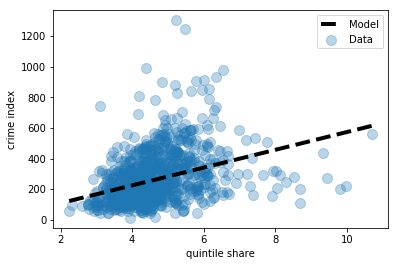

In [158]:
# Plot the orginal data (as before)
plt.scatter(crime_income_df['quintileshare'], crime_income_df['crimeindex'], alpha=0.3, label='Data', s=100);

# Generate and plot the model fit line
xs = np.linspace(crime_income_df['quintileshare'].min(), crime_income_df['quintileshare'].max())
ys = (57.9963 * xs) - 7.3352
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('quintile share')
plt.ylabel('crime index')
plt.legend();
plt.show()

In [39]:
# rename specific columns back to original names
crime_income_df.rename(columns={'crimeindex':'crime index',
                                   'inequalityexists':'inequality exists', 
                                   'povertyexists':'poverty exists'}, inplace=True)

In [40]:
crime_income_df.head()

,city,state,20th,40th,Median,60th,80th,95th,murders,murdersper100k,...,theftsper100k,autothefts,autotheftsper100k,arson,arsonper100k,crime index,income inequality,quintile share,inequality exists,poverty exists
0,Alabaster,Alabama,33578,61734,73325,85277,122176,177359,0.0,0.0,...,1389.3,21.0,63.2,NaN,NaN,115.9,143781,3.638573,0,1
1,Albertville,Alabama,17270,27280,32042,43119,73798,128375,0.0,0.0,...,1913.1,90.0,416.9,NaN,NaN,200.0,111105,4.273191,0,0
2,Anniston,Alabama,12553,22337,30539,39541,65472,143838,14.0,63.8,...,3188.3,110.0,501.0,NaN,NaN,1302.8,131285,5.215646,1,0
3,Athens,Alabama,16777,33804,45920,57566,104817,199193,1.0,3.8,...,2295.8,12.0,46.1,NaN,NaN,140.2,182416,6.247660,1,0
4,Auburn,Alabama,10718,26433,38912,53137,106853,198103,4.0,6.2,...,2242.8,101.0,155.8,NaN,NaN,217.4,187385,9.969491,1,0


In [46]:
df_ineq_exists = pd.DataFrame(crime_income_df[crime_income_df['inequality exists'] == 1])
df_no_ineq_exists = pd.DataFrame(crime_income_df[crime_income_df['inequality exists'] == 0])

df_ineq_ineqcrime = df_ineq_exists[['quintile share', 'crime index']]
df_no_ineq_ineqcrime = df_no_ineq_exists[['quintile share', 'crime index']]

corrs_ineq_ineqcrime = df_ineq_ineqcrime.corr()
corrs_no_ineq_ineqcrime = df_no_ineq_ineqcrime.corr()

In [47]:
corrs_ineq_ineqcrime

,quintile share,crime index
quintile share,1.000000,0.123457
crime index,0.123457,1.000000


In [48]:
corrs_no_ineq_ineqcrime

,quintile share,crime index
quintile share,1.000000,0.285439
crime index,0.285439,1.000000


In [119]:
crime_exist = crime_income_df["crime index"].median()
crimeind = crime_income_df['crime index']

crime_exists = [0]*len(crime_income_df)
for i in range(0,len(crime_income_df)):
    if crimeind[i] < crime_exist:
        crime_exists[i] = 0
    else:
        crime_exists[i] = 1
crime_income_df['high crime exists'] = crime_exists  
crime_income_df.head()

,city,state,20th,40th,Median,60th,80th,95th,murders,murdersper100k,...,autothefts,autotheftsper100k,arson,arsonper100k,crime index,income inequality,quintile share,inequality exists,poverty exists,high crime exists
0,Alabaster,Alabama,33578,61734,73325,85277,122176,177359,0.0,0.0,...,21.0,63.2,NaN,NaN,115.9,143781,3.638573,0,1,0
1,Albertville,Alabama,17270,27280,32042,43119,73798,128375,0.0,0.0,...,90.0,416.9,NaN,NaN,200.0,111105,4.273191,0,0,0
2,Anniston,Alabama,12553,22337,30539,39541,65472,143838,14.0,63.8,...,110.0,501.0,NaN,NaN,1302.8,131285,5.215646,1,0,1
3,Athens,Alabama,16777,33804,45920,57566,104817,199193,1.0,3.8,...,12.0,46.1,NaN,NaN,140.2,182416,6.247660,1,0,0
4,Auburn,Alabama,10718,26433,38912,53137,106853,198103,4.0,6.2,...,101.0,155.8,NaN,NaN,217.4,187385,9.969491,1,0,0


In [65]:
# see if we can use the income inequality data to predict crime
# Using the quintile share and the inequality exists data

from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

num_training = int(0.8*len(crime_income_df['quintile share']))
num_testing = int(0.2*len(crime_income_df['quintile share']))
print(num_training, num_testing, type(num_training), type(num_testing))


739 184 <class 'int'> <class 'int'>


In [140]:
inequality = np.array(crime_income_df['inequality exists'])
crimeind = np.array(crime_income_df['crime index'])
highcrime = np.array(crime_income_df['high crime exists'])
quintile = np.array(crime_income_df['quintile share'])

ci_train_X = quintile[:num_training]
ci_test_X = quintile[num_training:]
ci_train_y = highcrime[:num_training]
ci_test_y = highcrime[num_training:]
print(len(ci_train_X), len(ci_test_X), len(ci_train_y), len(ci_test_y))

739 185 739 185


In [141]:
def train_SVM(X, y, kernel='linear'):
    clf = SVC(kernel = kernel)
    clf.fit(X,y)
    return clf

In [142]:
ci_train_X = ci_train_X.reshape(-1, 1)
ci_test_X = ci_test_X.reshape(-1, 1)

ci_clf = train_SVM(ci_train_X, ci_train_y)
#print(ci_train_X.shape)
#print(ci_train_y.shape)

In [143]:
ci_predicted_train_y = ci_clf.predict(ci_train_X)
ci_predicted_test_y = ci_clf.predict(ci_test_X)

In [144]:
print(classification_report(ci_train_y,ci_predicted_train_y))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67       362
           1       0.69      0.59      0.64       377

   micro avg       0.65      0.65      0.65       739
   macro avg       0.66      0.66      0.65       739
weighted avg       0.66      0.65      0.65       739



In [145]:
print(classification_report(ci_test_y, ci_predicted_test_y))

              precision    recall  f1-score   support

           0       0.63      0.79      0.70       100
           1       0.64      0.45      0.53        85

   micro avg       0.63      0.63      0.63       185
   macro avg       0.64      0.62      0.61       185
weighted avg       0.63      0.63      0.62       185



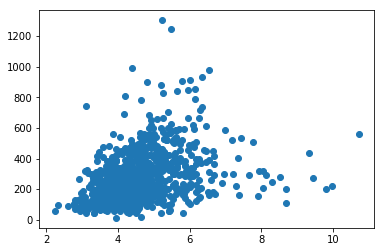

In [129]:
plt.scatter(crime_income_df['quintile share'], crime_income_df['crime index'])